In [100]:
import pysam, sys, os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
from pathlib import Path
import pyranges as pr
from statistics import mean


sys.path.append((os.path.abspath("..")))
from src.peaks import SlidingPeakCaller, OverlapPeakCaller
from src.util.read_l1 import read_rmsk, read_knrgl

## Read in ref and non-ref insertions

In [101]:
# read annotations of reference and non-reference insertions 
rmsk = read_rmsk("/raidixshare_logg01/mcuoco/internal/BSMN/resources/hs38DH/hs38DH.fa.out")
knrgl = read_knrgl("/raidixshare_logg01/mcuoco/internal/BSMN/resources/LIBD74/hs38DH_insertions.bed")

In [102]:
# label peaks with knrgl and rmsk annotations
def label_peaks(df, knrgl, rmsk, contigs=None):

	if "width" not in df.columns:
		df["width"] = df["Start"] - df["End"]

	if contigs:
		df = df.loc[df["Chromosome"].isin(contigs), :]
		l1 = {
			"knrgl": pr.PyRanges(knrgl.loc[knrgl["Chromosome"].isin(contigs), :]), 
			"rmsk": pr.PyRanges(rmsk.loc[rmsk["Chromosome"].isin(contigs), :])
		}
	else:
		l1 = {"knrgl": pr.PyRanges(knrgl), "rmsk": pr.PyRanges(rmsk)}

	for k, v in l1.items():
		df = pr.PyRanges(df)
		df_l1 = df.overlap(v).df.set_index(["Chromosome", "Start", "End"])
		df = df.df.set_index(["Chromosome", "Start", "End"])
		df[k] = df.index.isin(df_l1.index)
		df.reset_index(inplace=True)
		
	df["label"] = df.apply(lambda x: "knrgl" if x.knrgl else "rmsk" if x.rmsk else "other", axis=1)

	# if len(df_knrgl) == 0:
	# 	df = df.df.set_index(["Chromosome", "Start", "End"])
	# 	df["knrgl"] = False
	# 	df["label"] = "other"
	# 	print(f"0/{len(df)} peaks covering 0/{len(knrgl)} knrgl L1 annotations")
	# 	return df
	
	df = pr.PyRanges(df)
	knrgl_covered = len(l1["knrgl"].overlap(df))
	knrgl_peaks = sum(df.df["label"] == "knrgl")
	
	print(f"{knrgl_peaks}/{len(df)} peaks covering {knrgl_covered}/{len(knrgl)} knrgl L1 annotations")

	return df.df

## Evaluate 750 x 250 windows

In [ ]:
import joblib 

bams = glob.glob("/home/mcuoco/workflows/sz_slavseq/results/align/tags/hs38DH/LIBD74/*/*.bam")

def run(b):
	with pysam.AlignmentFile(b) as bam:
		peaks = SlidingPeakCaller(bam, read_filter=False, window_size=750, step_size=250, min_reads = 3, merge=False, bg_sizes=None).run_peak_caller()
	peaks.rename(columns={"chr":"Chromosome", "start":"Start", "end":"End"}, inplace=True)
	peaks = label_peaks(peaks, knrgl, rmsk)

	# add to results
	res = {}
	res["sample"] = Path(b).stem
	res["dna_type"] = Path(b).parent.name
	res["depth"] = sum(peaks["count_fwd"]) + sum(peaks["count_rev"])
	res["windows"] = len(peaks)
	res["knrgl"] = sum(peaks["label"] == "knrgl")
	res["rmsk"] = sum(peaks["label"] == "rmsk")
	res["other"] = sum(peaks["label"] == "other")

	with pysam.AlignmentFile(b) as bam:
		peaks = SlidingPeakCaller(bam, read_filter=True, window_size=750, step_size=250, min_reads = 3, merge=False, bg_sizes=None).run_peak_caller()
	peaks.rename(columns={"chr":"Chromosome", "start":"Start", "end":"End"}, inplace=True)
	peaks = label_peaks(peaks, knrgl, rmsk)

	# add to results
	res1 = {}
	res1["sample"] = Path(b).stem
	res1["dna_type"] = Path(b).parent.name
	res1["depth"] = sum(peaks["count_fwd"]) + sum(peaks["count_rev"])
	res1["windows"] = len(peaks)
	res1["knrgl"] = sum(peaks["label"] == "knrgl")
	res1["rmsk"] = sum(peaks["label"] == "rmsk")
	res1["other"] = sum(peaks["label"] == "other")

	return pd.DataFrame.from_records([res, res1])

res = joblib.Parallel(n_jobs=32)(joblib.delayed(run)(b) for b in bams)
res = pd.DataFrame.from_records(res)
res = pd.melt(res, id_vars=["sample","dna_type"], value_vars=["other", "knrgl", "rmsk"], var_name="metric", value_name="value")
fig = sns.boxplot(res, x="metric", y="value", order = ["other", "rmsk", "knrgl"])
fig.set(yscale="log")

In [81]:
import numpy as np

bams = ["/home/mcuoco/workflows/sz_slavseq/results/align/tags/hs38DH/LIBD74/bulk/gDNA_usd2.bam","/home/mcuoco/workflows/sz_slavseq/results/align/tags/hs38DH/LIBD74/mda/usd02_A2_S128.bam"]

b = bams[0]
res = {"Chromosome": [], "Start": [], "End": [], "YA" : [], "YG" : [] ,"YS": [], "mapq": [], "nSA": [], "nXA": [], "nR1": [], "nR2": [], "nPrim": [], "nSec": [], "nSupp": []}
with pysam.AlignmentFile(b) as bam:
	peaks = SlidingPeakCaller(bam, read_filter=False, window_size=750, step_size=250, min_reads = 3, merge=False, bg_sizes=None).run_peak_caller()
	peaks.rename(columns={"chr":"Chromosome", "start":"Start", "end":"End"}, inplace=True)
	peaks = label_peaks(peaks, knrgl, rmsk)

	# randomly sample peaks
	iknrgl, = np.where(peaks["label"] == "knrgl")
	irmsk, = np.where(peaks["label"] == "rmsk")
	iother, = np.where(peaks["label"] == "other")
	inds = np.concatenate([np.random.choice(iknrgl, 200), np.random.choice(irmsk, 200) , np.random.choice(iother, 200)])
	peaks = peaks.iloc[inds,:]

	# collect features
	for p in peaks.itertuples():
		ya, yg, ys, mapq = [], [], [], []
		nR1, nR2, nSA, nXA, nPrim, nSec, nSupp = 0, 0, 0, 0, 0, 0, 0
		for r in bam.fetch(p.Chromosome, p.Start, p.End, multiple_iterators=True):
			
			if r.has_tag("YA"):
				ya.append(r.get_tag("YA"))
			if r.has_tag("YG"):
				yg.append(r.get_tag("YG"))
			if r.has_tag("YS"):
				ys.append(r.get_tag("YS"))
			mapq.append(r.mapping_quality)

			if r.is_read1:
				nR1 += 1
			else:
				nR2 += 1

			if r.is_secondary:
				nSec += 1
			elif r.is_supplementary:	
				nSupp += 1
			else:
				nPrim += 1
			nSA += r.has_tag("SA")
			nXA += r.has_tag("XA")


		res["Chromosome"].append(p.Chromosome)
		res["Start"].append(p.Start)
		res["End"].append(p.End)
		if len(ya) == 0:
			for k in ["YA", "YG", "YS", "mapq", "nSA", "nXA", "nR1", "nR2", "nPrim", "nSec", "nSupp"]:
				res[k].append(0)
		else:
			res["YA"].append(mean(ya))
			res["YG"].append(mean(yg))
			res["YS"].append(mean(ys))
			res["mapq"].append(mean(mapq))
			res["nR1"].append(nR1)
			res["nR2"].append(nR2)
			res["nSA"].append(nSA)
			res["nXA"].append(nXA)
			res["nPrim"].append(nPrim)
			res["nSec"].append(nSec)
			res["nSupp"].append(nSupp)
				
	res = pd.DataFrame.from_dict(res)
	res["label"] = peaks["label"].values
	res["total"] = res["nR1"] + res["nR2"]

815/175449 peaks covering 184/267 knrgl L1 annotations


In [83]:
df = res.melt(id_vars=["Chromosome", "Start", "End", "label"], value_vars=["YA", "YG", "YS", "mapq", "nSA", "nXA", "nR1", "nR2", "nPrim", "nSec", "nSupp", "total"], var_name="metric", value_name="value")

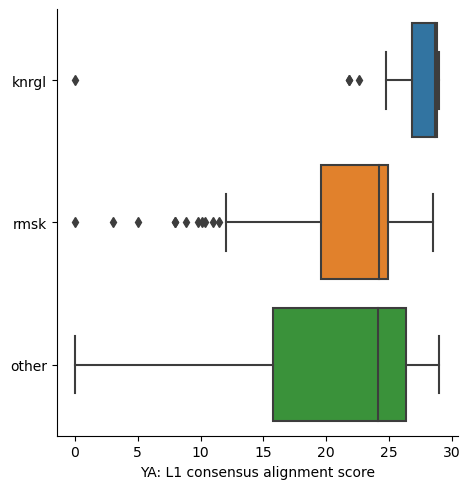

<Figure size 640x480 with 0 Axes>

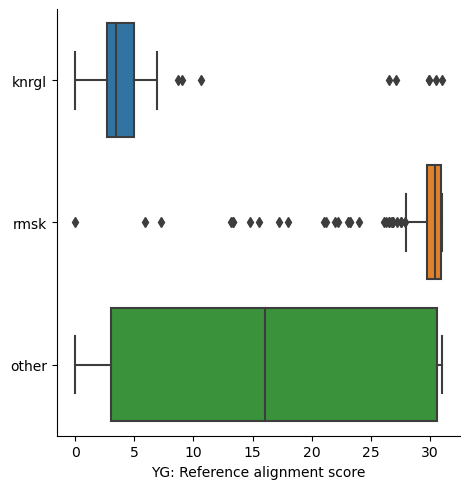

<Figure size 640x480 with 0 Axes>

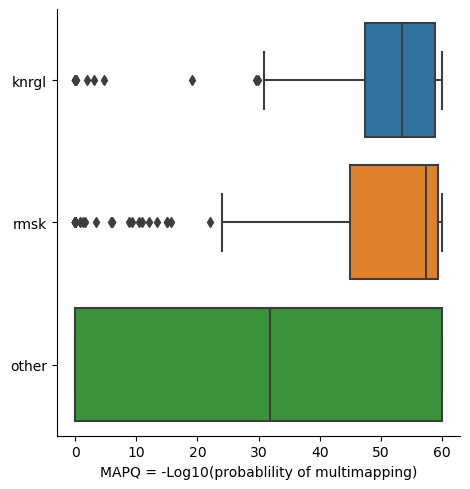

In [97]:
fig = sns.catplot(data=res, y = "label", x = "YA", kind="box", order=["knrgl", "rmsk", "other"])
fig.set(xlabel="YA: L1 consensus alignment score", ylabel="")
plt.show()
plt.clf()
fig = sns.catplot(data=res, y = "label", x = "YG", kind="box", order=["knrgl", "rmsk", "other"])
fig.set(xlabel="YG: Reference alignment score", ylabel="")
plt.show()
plt.clf()
fig = sns.catplot(data=res, y = "label", x = "mapq", kind="box", order=["knrgl", "rmsk", "other"])
fig.set(xlabel="MAPQ = -Log10(probablility of multimapping)", ylabel="")
plt.show()

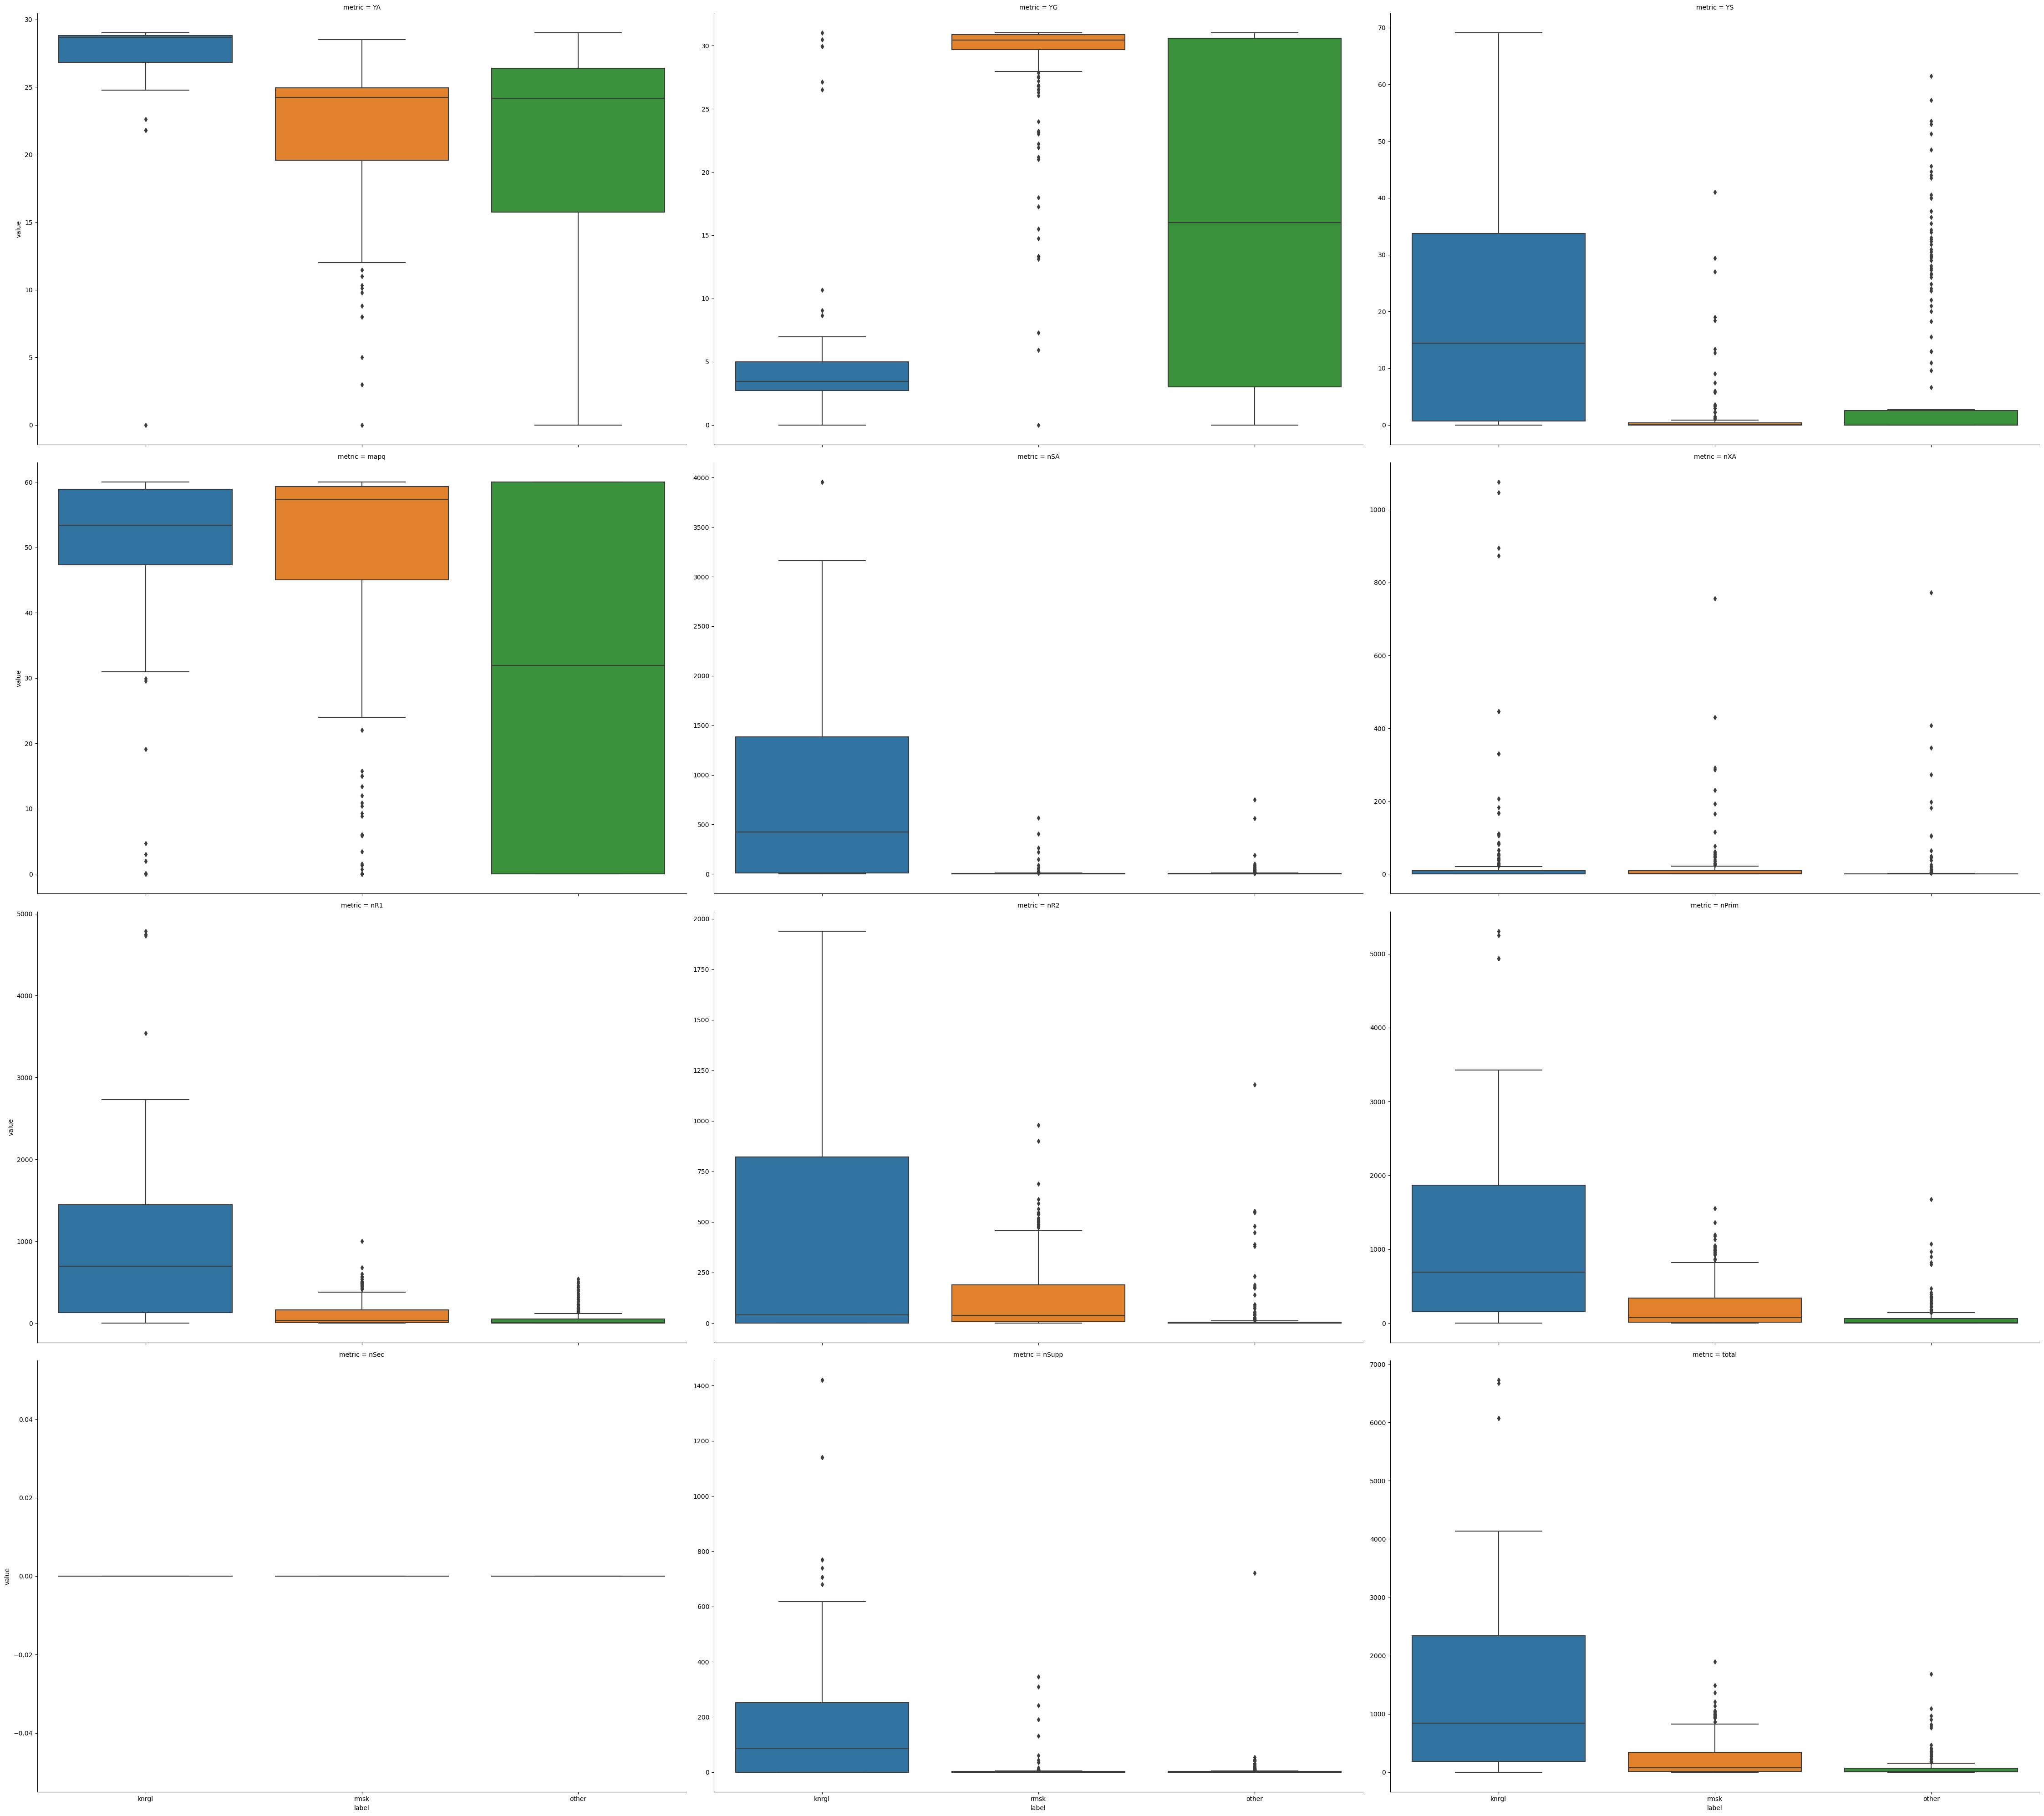

In [92]:
sns.catplot(data=df, col="metric", y="value", x="label", kind="box", height=10, aspect=1.5, sharey=False, col_wrap=3)

## Label knrgl in bulk that have coverage

In [98]:
bulk_fn = "/home/mcuoco/workflows/sz_slavseq/results/align/tags/hs38DH/LIBD74/bulk/gDNA_usd2.bam"

with pysam.AlignmentFile(bulk_fn) as bam:
	res = [bam.count(i.Chromosome, i.Start, i.End) for i in knrgl.itertuples()]
knrgl["total_coverage"] = res

res = {"YA" : [], "YG" : [] ,"YS": [], "mapq": [], "nfwd": [], "nrev": [], "nSA": [], "nXA": []}

with pysam.AlignmentFile(bulk_fn) as bam:
	for i in knrgl.itertuples():
		ya, yg, ys, mapq = [], [], [], []
		nfwd, nrev, nSA, nXA = 0, 0, 0, 0

		for r in bam.fetch(i.Chromosome, i.Start, i.End, multiple_iterators=True):
			if (
				r.is_read1
				and (not r.is_unmapped)
				and (not r.is_secondary)
				and (not r.is_supplementary)
				# and (not r.has_tag("XA"))
				# and (not r.has_tag("SA"))
				and (r.has_tag("YA") and r.has_tag("YG"))
				and (r.get_tag("YA") > r.get_tag("YG"))
				# and (r.get_tag("YA") > 20)
				# and (r.mapping_quality >= 60)
			):
				ya.append(r.get_tag("YA"))
				yg.append(r.get_tag("YG"))
				ys.append(r.get_tag("YS"))
				mapq.append(r.mapping_quality)
				if r.is_reverse:
					nrev += 1
				else:
					nfwd += 1
				nSA += r.has_tag("SA")
				nXA += r.has_tag("XA")
		if len(ya) == 0:
			res["YA"].append(0)
			res["YG"].append(0)
			res["YS"].append(0)
			res["mapq"].append(0)
			res["nfwd"].append(0)
			res["nrev"].append(0)
			res["nSA"].append(0)
			res["nXA"].append(0)
			continue
		res["YA"].append(mean(ya))
		res["YG"].append(mean(yg))
		res["YS"].append(mean(ys))
		res["mapq"].append(mean(mapq))
		res["nfwd"].append(nfwd)
		res["nrev"].append(nrev)
		res["nSA"].append(nSA)
		res["nXA"].append(nXA)

knrgl["mean_YA"] = res["YA"]
knrgl["mean_YG"] = res["YG"]
knrgl["mean_YS"] = res["YS"]
knrgl["mean_mapq"] = res["mapq"]
knrgl["nfwd"] = res["nfwd"]
knrgl["nrev"] = res["nrev"]
knrgl["nSA"] = res["nSA"]
knrgl["nXA"] = res["nXA"]
knrgl["total_primaryr1"] = knrgl["nfwd"] + knrgl["nrev"]

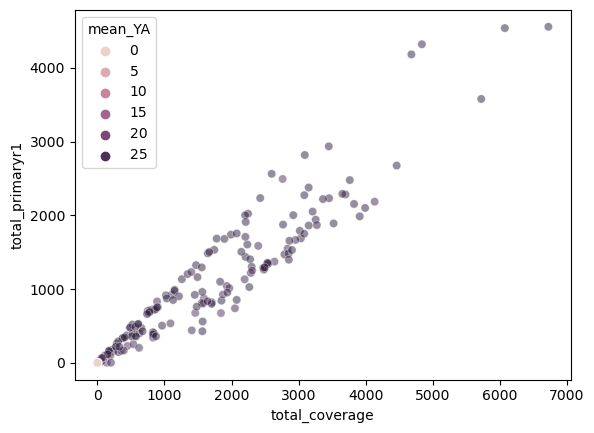

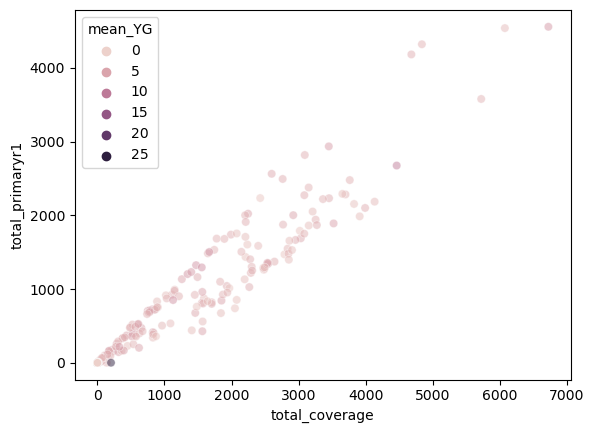

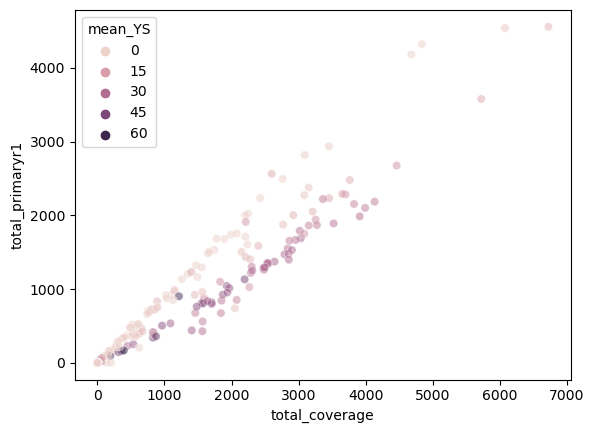

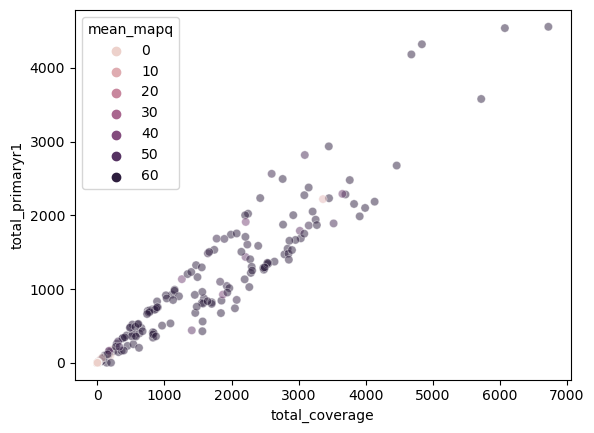

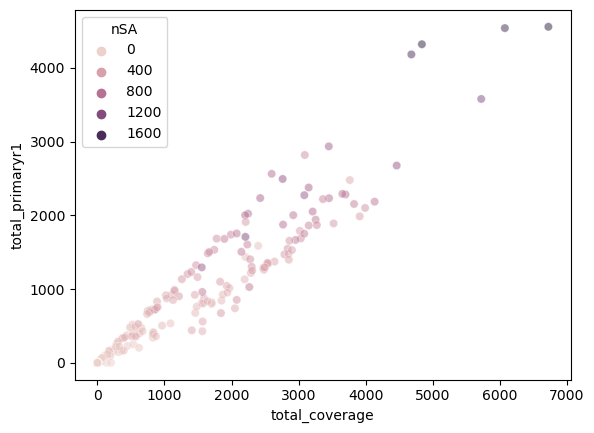

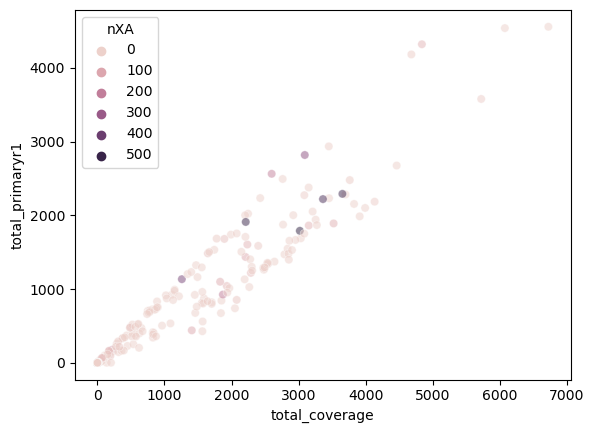

In [99]:
for i in ["mean_YA", "mean_YG", "mean_YS", "mean_mapq", "nSA", "nXA"]:
	plt.clf()
	sns.scatterplot(knrgl, x='total_coverage', y='total_primaryr1', hue = i, alpha=0.5)
	plt.show()

## Theoretical PPV

In [ ]:
bal = [1, 10, 100, 1000, 10000, 100000]
fpr = [0.00001, 0.0001, 0.001, 0.01, 0.05]

# Wrangle
plot_df = []
for f in fpr:
	for b in bal:
		ppv = {}
		ppv["tpr"] = 0.8
		ppv["fpr"] = f
		ppv["nKNRGL"] = 1
		ppv["nOTHER"] = b
		ppv["tp"] = ppv["nKNRGL"] * ppv["tpr"]
		ppv["fp"] = ppv["nOTHER"] * ppv["fpr"]
		ppv["ppv"] = ppv["tp"] / (ppv["tp"] + ppv["fp"])
		plot_df.append(ppv.copy())

plot_df = (
    pd.DataFrame.from_records(plot_df)
    .groupby(["nOTHER", "fpr"])
    .mean(["tp", "fp", "ppv", "tpr"])
    .reset_index()
)

fig = sns.lineplot(data=plot_df, x="nOTHER", y="ppv", hue="fpr", markers=True)
fig.set(xscale="log", ylim=(0,1))
fig.set(ylabel="PPV", xlabel="OTHER : Somatic insertion ratio", title="Theoretical Positive-Predictive Value (PPV = TP/(TP+FP))")
fig.get_legend().set_title("False Positive Rate")
sns.despine()

In [ ]:
def test_peaks(bam_fn, fxn, kwargs, contigs=None):
	with pysam.AlignmentFile(bam_fn) as bam:
		pc = fxn(bam, **kwargs)
		peaks = pc.run_peak_caller(contigs)
		peaks.rename(columns={"chr":"Chromosome", "start":"Start", "end":"End"}, inplace=True)
		return label_peaks(peaks, knrgl, contigs)

In [ ]:
fn = {
	"bulk": "/home/mcuoco/workflows/sz_slavseq/results/align/tags/hs38DH/LIBD74/bulk/gDNA_usd2.bam",
	"mda": "/home/mcuoco/workflows/sz_slavseq/results/align/tags/hs38DH/LIBD74/mda/usd02_A2_S128.bam"
}

tests = {
	"Sliding 750x250 NoFilter NoMerge NoBG": {"fxn": SlidingPeakCaller, "kwargs": {"read_filter": False, "merge": False, "window_size": 750, "step_size": 250, "bg_sizes": None}},
	"Sliding 750x250 NoMerge NoBG": {"fxn": SlidingPeakCaller, "kwargs": {"read_filter": True, "merge": False, "window_size": 750, "step_size": 250, "bg_sizes": None}},
	"Sliding 750x250 NoBG": {"fxn": SlidingPeakCaller, "kwargs": {"read_filter": True, "merge": True, "window_size": 750, "step_size": 250, "bg_sizes": None}},
	"OverlappingReads": {"fxn": OverlapPeakCaller, "kwargs": {"read_filter": True}},
	"Sliding 750x250": {"fxn": SlidingPeakCaller, "kwargs": {"read_filter": True, "merge": True, "window_size": 750, "step_size": 250, "bg_sizes": [5000, 10000, 20000]}},
    "Sliding 750x1": {"fxn": SlidingPeakCaller, "kwargs": {"read_filter": True, "merge": True, "window_size": 750, "step_size": 1, "bg_sizes": [5000, 10000, 20000]}},
    "Sliding 500x1": {"fxn": SlidingPeakCaller, "kwargs": {"read_filter": True, "merge": True, "window_size": 500, "step_size": 1, "bg_sizes": [5000, 10000, 20000]}},
    "Sliding 400x1": {"fxn": SlidingPeakCaller, "kwargs": {"read_filter": True, "merge": True, "window_size": 400, "step_size": 1, "bg_sizes": [5000, 10000, 20000]}},
    "Sliding 300x1": {"fxn": SlidingPeakCaller, "kwargs": {"read_filter": True, "merge": True, "window_size": 300, "step_size": 1, "bg_sizes": [5000, 10000, 20000]}},
}

In [ ]:
df_list = []
for n, f in fn.items():
	for k, v in tests.items():
		print(f"Running {k} on {n}...")
		df = test_peaks(f, contigs = ["chr5"], **v)
		df["file"] = n
		df["name"] = k
		df_list.append(df.copy())
		
df = pd.concat(df_list)

In [ ]:
plt.clf()
fig, axes = plt.subplots(2, 1)
fig1 = sns.boxplot(ax = axes[0], data = df, y = "name", x = "count", hue="label", dodge=True)
fig1.set(xscale = "log", xlabel = "# reads", ylabel = "Peak caller")
axes[0].legend_.remove()
fig2 = sns.boxplot(ax = axes[1], data=df, y = "name", x = "width", hue="label", dodge=True)
fig2.set(xlabel = "width (bp)", ylabel = "Peak caller")
plt.tight_layout()
sns.move_legend(axes[1],loc="center right", bbox_to_anchor=(1.3, 1.2),title=None,frameon=False,)
plt.show()

In [ ]:
# plot
fig = sns.JointGrid(data=df.reset_index(), x="width", y="nreads", hue="label", marginal_ticks=True)
fig.plot_joint(sns.scatterplot, alpha = 0.5)
fig.ax_joint.set(yscale = "log")

fig.plot_marginals(sns.histplot, bins=100, element="step", fill=False)
fig.ax_marg_x.set(yscale = "log")
fig.ax_marg_y.set(xscale = "log")
fig.ax_joint.set(xlabel = "Peak width (bp)", ylabel = "Number of reads")
plt.show()